## ECG Anomaly Detection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# set random seed
# seed(10)
# tf.random.set_seed(10)


In [ ]:
# set random seed
# seed(10)
# tf.random.set_seed(10)

# Data loading and pre-processing

In [ ]:
# The ECG dataset containing a single anomaly corresponding to a pre-ventricular contraction
# dataset from http://www.cs.ucr.edu/~eamonn/discords/
# import pickle
# train_data_dir= '/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275_train.pkl'
# test_data_dir= '/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275_test.pkl'
# with open(train_data_dir, 'rb') as f:
#     train_raw = pickle.load(f)
# with open(test_data_dir, 'rb') as f:
#     test_raw = pickle.load(f)

In [ ]:
# train_label = np.array(train_raw)[:,2]

In [ ]:
# plt.plot(train_label)

In [ ]:
#only use target 1 & target 2

# train = pd.DataFrame(train_raw,columns=['Target1','Target2','label']).iloc[:,:2]

# test = pd.DataFrame(test_raw,columns=['Target1','Target2','label']).iloc[:,:2]

In [ ]:
# print("Training dataset shape:", train.shape)
# print("Test dataset shape:", test.shape)

In [ ]:
# train data plot
# fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
# ax.plot(train['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
# ax.plot(train['Target2'], label='Target2', color='red', animated = True, linewidth=1)
# plt.legend(loc='lower left')
# ax.set_title('ECG Training Data', fontsize=16)
# plt.show()

In [ ]:
# normalize the data
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(train)
# X_test = scaler.transform(test)
# scaler_filename = "/content/gdrive/MyDrive/Colab Notebooks/научка/chfdb_chf01_275.txt"
# joblib.dump(scaler, scaler_filename)

In [ ]:
# reshape inputs for LSTM [samples, timesteps, features]
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# print("Training data shape:", X_train.shape)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# print("Test data shape:", X_test.shape)

In [ ]:
# print(X_train)

In [ ]:
# define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(24, activation='relu', return_sequences=True,
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [ ]:
# create the autoencoder model
# model = autoencoder_model(X_train)
# model.compile(optimizer='adam', loss='mae')
# model.summary()

In [ ]:
# fit the model to the data
# nb_epochs = 100
# batch_size = 20
# history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
#                     validation_split=0.05).history

In [ ]:
from keras.models import load_model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/научка/ecg_model.h5")

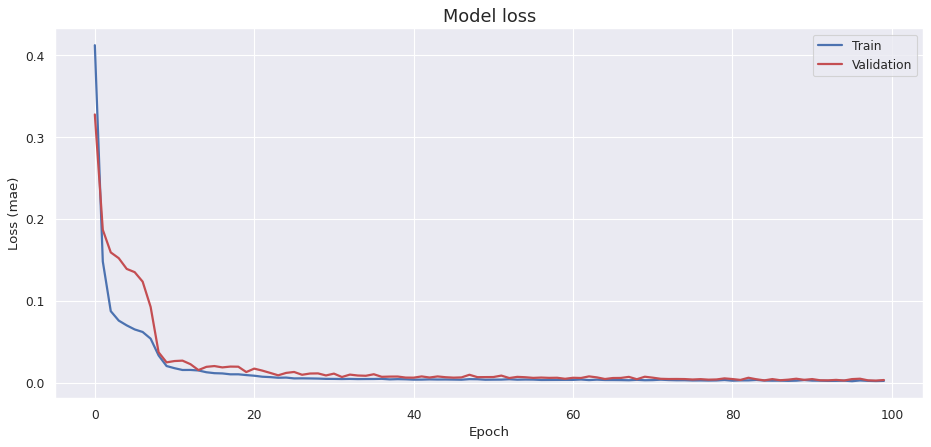

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function

58/58 [==============================] - 1s 3ms/step


(0.0, 0.1)

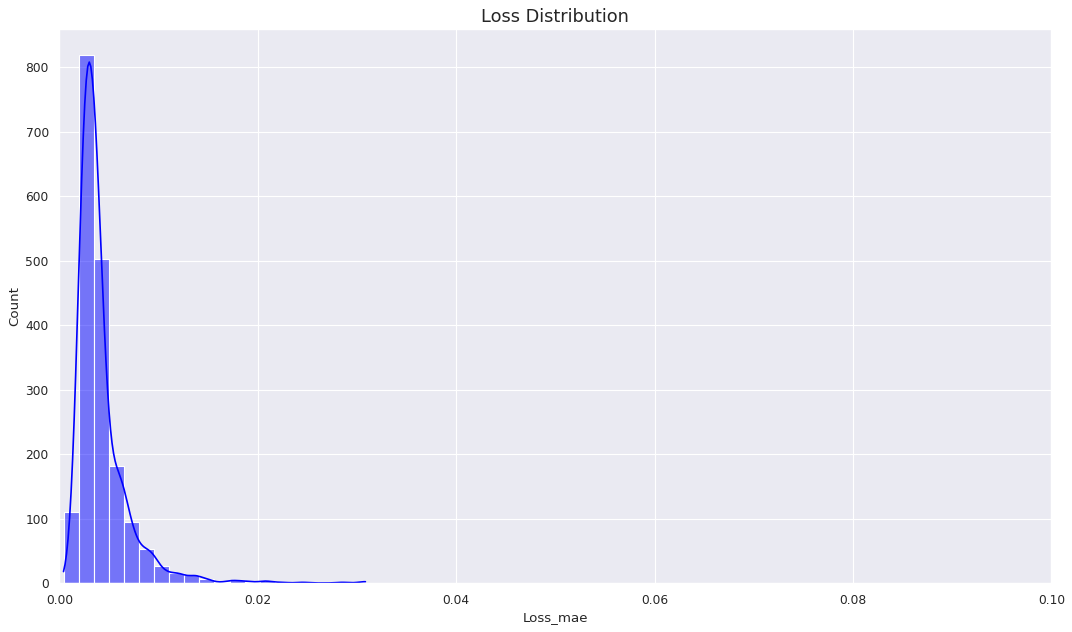

In [ ]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [ ]:
from torch.nn import BCELoss
import torch
loss = BCELoss()
entropy_list = []
threshold_list = []
for threshold in np.arange(0, 1, 0.001):
    anomalies = scored['Loss_mae'] > threshold
    anomalies = torch.Tensor(anomalies.replace({True:1, False:0}).values)
    target = torch.Tensor(train_label)

    entropy_val = loss(anomalies, target)
    entropy_list.append(entropy_val)
    threshold_list.append(threshold)

min_entropy_index = np.argmin(entropy_list)
min_entropy = min(entropy_list)

print("минимальная энтропия достигается при пороге:", threshold_list[min_entropy_index])
print("минимальное значение энтропии:", min_entropy)

минимальная энтропия достигается при пороге: 0.031
минимальное значение энтропии: tensor(0.)


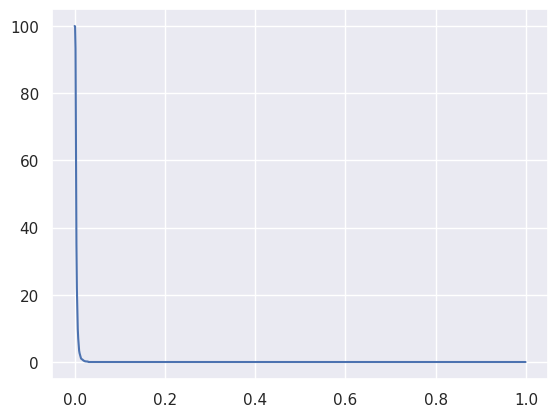

In [ ]:
plt.plot(threshold_list, entropy_list)

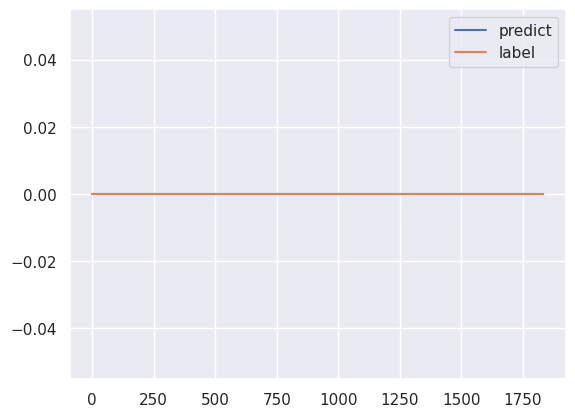

In [ ]:
plt.plot((scored['Loss_mae'] > threshold_list[min_entropy_index]).replace({True:1, False:0}).values, label = 'predict')
plt.plot(train_label, label = 'label')
plt.legend()


In [ ]:
# calculate the loss on the test set
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

anomaly threshold = 0.030849961208601173
58/58 [==============================] - 0s 3ms/step


,Loss_mae,Threshold,Anomaly
0,0.002793,0.03085,False
1,0.002743,0.03085,False
2,0.003177,0.03085,False
3,0.003076,0.03085,False
4,0.003258,0.03085,False


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:695: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(self.ylim)


<Axes: >

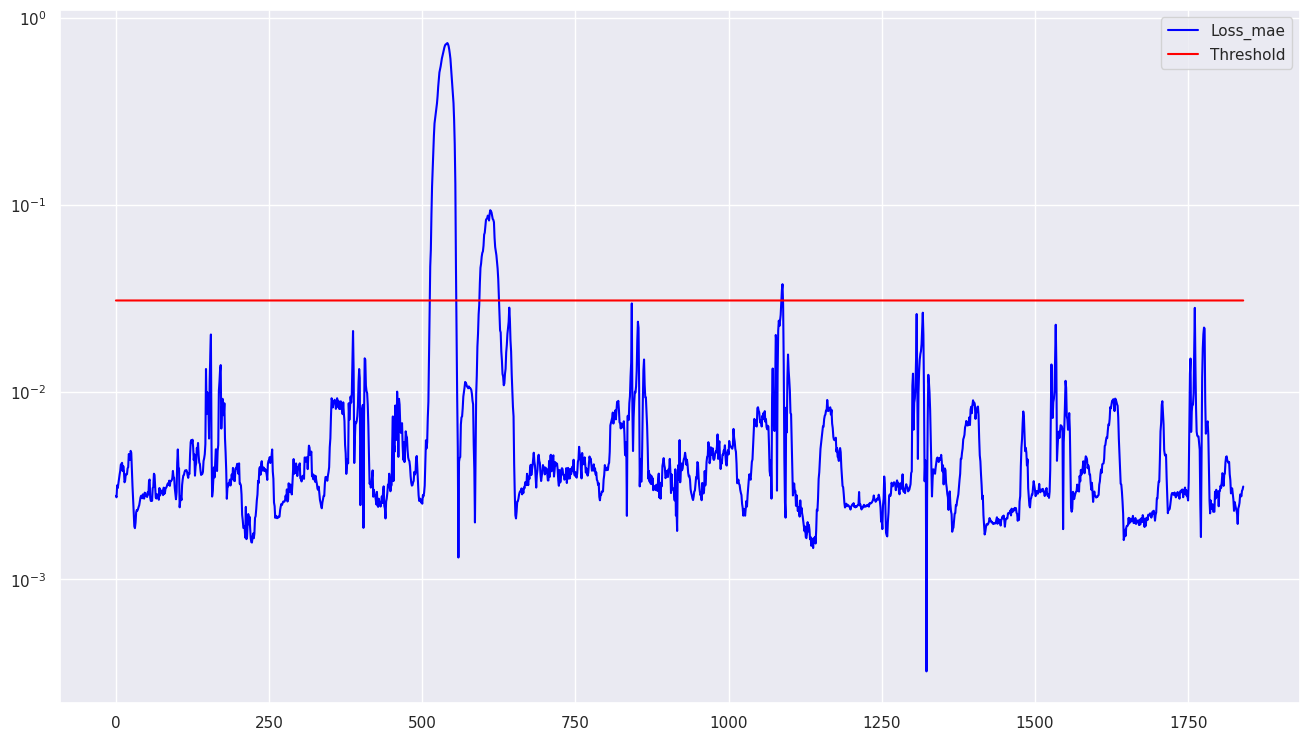

In [ ]:
# test set에 대한 결과
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

(0.0, 0.1)

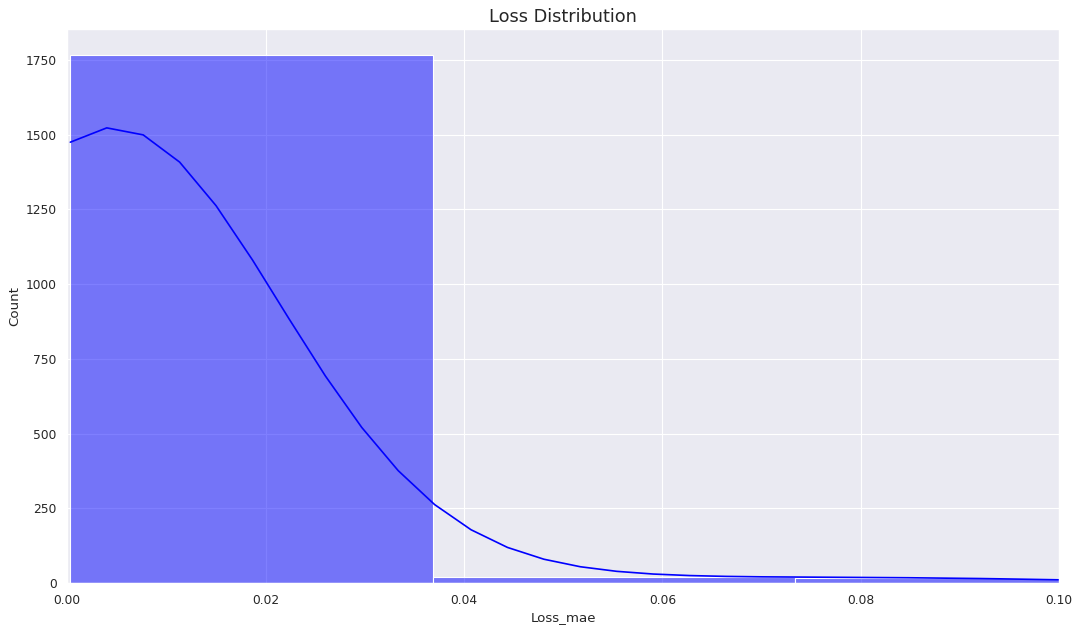

In [ ]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

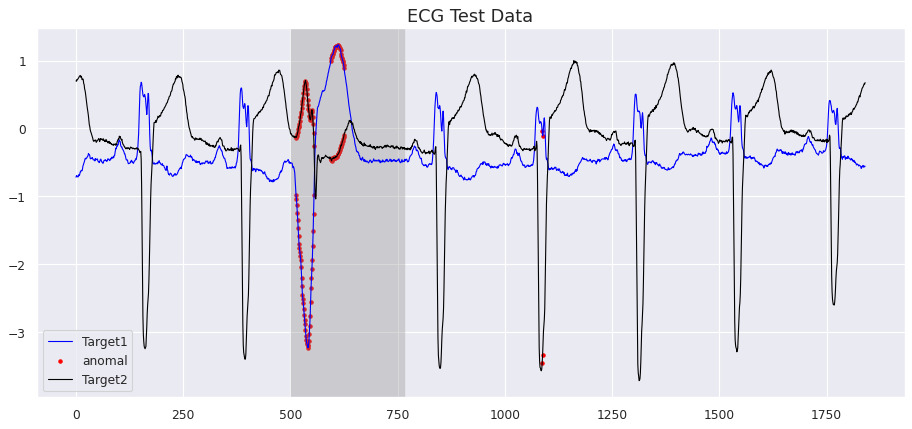

In [ ]:
#whole test data
test_ = pd.DataFrame(test_raw,columns=['Target1','Target2','label'])

#make plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red')
ax.plot(test_['Target2'], label='Target2', color='black', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'], marker='.', color='red')
plt.legend(loc='lower left')
ax.set_title('ECG Test Data', fontsize=16)
plt.axvspan(min(test_[test_['label']==1].index), max(test_[test_['label']==1].index), facecolor='gray', alpha=0.3)

plt.show()

In [ ]:
# save all model information, including weights, in h5 format
# model.save("/content/gdrive/MyDrive/Colab Notebooks/научка/ecg_model.h5")
# print("Model saved")

In [ ]:
from torch.nn import BCELoss
import torch
loss = BCELoss()
entropy_list = []
threshold_list = []
for threshold in np.arange(0, 1, 0.001):
    anomalies = scored['Loss_mae'] > threshold
    anomalies = torch.Tensor(anomalies.replace({True:1, False:0}).values)
    target = torch.Tensor(test_['label'].values)

    entropy_val = loss(anomalies, target)
    entropy_list.append(entropy_val)
    threshold_list.append(threshold)

min_entropy_index = np.argmin(entropy_list)
min_entropy = min(entropy_list)

print("минимальная энтропия достигается при пороге:", threshold_list[min_entropy_index])
print("минимальное значение энтропии:", entropy_list[min_entropy_index])

минимальная энтропия достигается при пороге: 0.038
минимальное значение энтропии: tensor(10.5921)


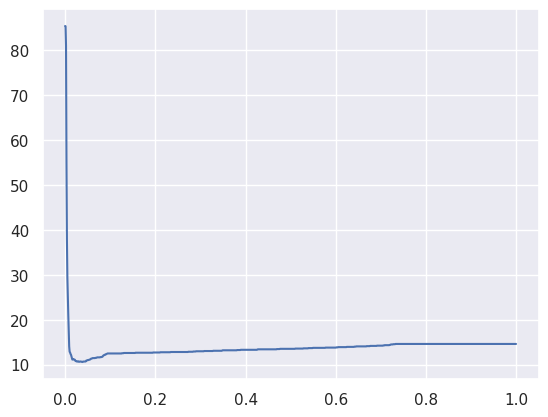

In [ ]:
plt.plot(threshold_list, entropy_list)

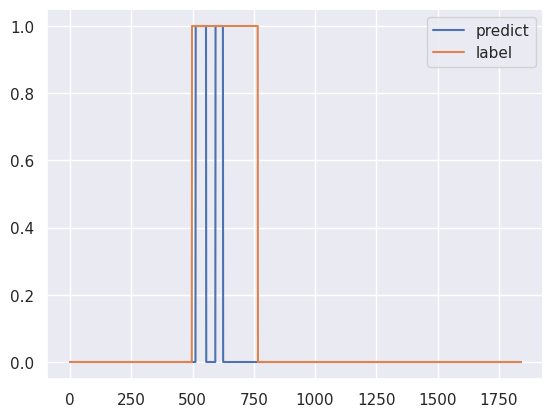

In [ ]:
plt.plot((scored['Loss_mae'] > threshold_list[min_entropy_index]).replace({True:1, False:0}).values, label = 'predict')
plt.plot(test_['label'].values, label = 'label')
plt.legend()


In [ ]:
# model.save("/content/gdrive/MyDrive/Colab Notebooks/научка/ecg_model.h5")